### Predicting Music Genre: A Data-Driven Approach to Analyzing Musical Structure

**Introduction**

In today’s music landscape, where vast amounts of songs are released daily, the ability to accurately categorize music by genre has become invaluable for streaming platforms, record labels, and listeners alike. With genre serving as a primary organizing principle in the music industry, efficient and scalable solutions for genre classification are essential to help listeners navigate this abundance. Traditional genre classification relies on subjective judgment and domain expertise, but with advancements in machine learning, we now have the tools to analyze and categorize music based on quantifiable features.

**Objective** 

This project leverages machine learning techniques to develop a genre prediction model capable of analyzing the structural and acoustic attributes of a song. By examining detailed audio features such as Mel-frequency cepstral coefficients (MFCCs), spectral centroid, chroma frequencies, and rhythmic properties, this model aims to categorize music with precision. Each feature represents a distinct aspect of a song’s sonic profile, allowing the model to distinguish subtle nuances that characterize different genres, from the rhythmic complexity of jazz to the bright textures of pop. Through this analytical approach, this model provides a deeper, data-driven understanding of genre classification, setting a foundation for applications across the music industry. 

This project aims to develop and evaluate a robust genre classification model using machine learning algorithms, including K-Nearest Neighbors (KNN), Random Forest, and Convolutional Neural Networks (CNN). By comparing these models across metrics such as accuracy, precision, recall, and F1-score, we aim to identify the most effective model for genre prediction. 

In [1]:
import kagglehub
import os
import pandas as pd
import librosa
import numpy as np
import IPython
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from IPython.display import Audio, display
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.decomposition import PCA
from matplotlib.colors import ListedColormap
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import learning_curve
from sklearn.ensemble import RandomForestClassifier
import warnings
warnings.filterwarnings('ignore')
from sklearn.tree import plot_tree
from sklearn.inspection import permutation_importance
# Import necessary libraries
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
import librosa
import librosa.display

## 1. Data Loading and Cleaning

In [2]:
# Download latest version
path = kagglehub.dataset_download("andradaolteanu/gtzan-dataset-music-genre-classification")

print("Path to dataset files:", path)

Path to dataset files: /Users/raghavirajumohan/.cache/kagglehub/datasets/andradaolteanu/gtzan-dataset-music-genre-classification/versions/1


In [3]:
# Define the path to the dataset folder
dataset_folder = "/Users/raghavirajumohan/.cache/kagglehub/datasets/andradaolteanu/gtzan-dataset-music-genre-classification/versions/1/data"

# List all files in the directory

files = os.listdir(dataset_folder)
print("Files in dataset folder:", files)

Files in dataset folder: ['genres_original', 'features_30_sec.csv', 'images_original', 'features_3_sec.csv']


**1. Dataset with Extracted Features**
The extracted features dataset is a structured format (e.g., a CSV or Pandas DataFrame) that contains pre-computed numerical features for each audio file.
This dataset is created by processing each audio file individually, extracting relevant audio features (such as MFCCs, chroma, spectral features), and then storing these features as rows in a table, where each row represents an audio file.
The benefit of having this pre-computed dataset is that it enables faster experimentation and model training without reloading and reprocessing the raw audio files each time. This structured dataset can be directly used as input for machine learning models.

**2. Separate Audio Files**
The individual audio files are the raw data used for feature extraction.
During the feature extraction process, each audio file is read, and features are computed for it. The extracted features are then added to the structured dataset.
The audio files can also be visualized directly (e.g., with waveforms or spectrograms) for analysis or used in models that require raw audio input, such as Convolutional Neural Networks (CNNs) that operate on spectrogram images.

### i. Checking the Data

In [4]:
# Load the dataset
csv_file = os.path.join(dataset_folder, "features_3_sec.csv") 
music = pd.read_csv(csv_file)
music = music.drop(music.columns[0], axis=1)

# Display the first few rows
music.head(5)

length  chroma_stft_mean  chroma_stft_var  rms_mean   rms_var  \
0   66149          0.335406         0.091048  0.130405  0.003521   
1   66149          0.343065         0.086147  0.112699  0.001450   
2   66149          0.346815         0.092243  0.132003  0.004620   
3   66149          0.363639         0.086856  0.132565  0.002448   
4   66149          0.335579         0.088129  0.143289  0.001701   

   spectral_centroid_mean  spectral_centroid_var  spectral_bandwidth_mean  \
0             1773.065032          167541.630869              1972.744388   
1             1816.693777           90525.690866              2010.051501   
2             1788.539719          111407.437613              2084.565132   
3             1655.289045          111952.284517              1960.039988   
4             1630.656199           79667.267654              1948.503884   

   spectral_bandwidth_var  rolloff_mean  ...  mfcc16_var  mfcc17_mean  \
0           117335.771563   3714.560359  ...   39.687145    -3.241280   
1            65671.875673   3869.682242  ...   64.748276    -6.055294   
2            75124.921716   3997.639160  ...   67.336563    -1.768610   
3            82913.639269   3568.300218  ...   47.739452    -3.841155   
4            60204.020268   3469.992864  ...   30.336359     0.664582   

   mfcc17_var  mfcc18_mean  mfcc18_var  mfcc19_mean  mfcc19_var  mfcc20_mean  \
0   36.488243     0.722209   38.099152    -5.050335   33.618073    -0.243027   
1   40.677654     0.159015   51.264091    -2.837699   97.030830     5.784063   
2   28.348579     2.378768   45.717648    -1.938424   53.050835     2.517375   
3   28.337118     1.218588   34.770935    -3.580352   50.836224     3.630866   
4   45.880913     1.689446   51.363583    -3.392489   26.738789     0.536961   

   mfcc20_var  label  
0   43.771767  blues  
1   59.943081  blues  
2   33.105122  blues  
3   32.023678  blues  
4   29.146694  blues  

[5 rows x 59 columns]

In [5]:
# Drop rows with NA values
music.dropna(inplace=True)

In [6]:
dirname = "/Users/raghavirajumohan/.cache/kagglehub/datasets/andradaolteanu/gtzan-dataset-music-genre-classification/versions/1/data/genres_original"

# Save audio paths and labels
audio_paths = []
# audio_dict = {}
audio_label = []
# Print all the files in different directories
for root, dirs, files in os.walk(dirname, topdown=False):
    for filenames in files:
        if filenames.find('.wav') != -1:

            audio_paths.append(os.path.join(root, filenames))
            filenames = filenames.split('.', 1)
            filenames = filenames[0]
            audio_label.append(filenames)
audio_paths = np.array(audio_paths)
audio_label = np.array(audio_label)

### ii. Audio Processing - from audio files 

In [7]:
# Loading a sample audio from the dataset
sample_audio = "/Users/raghavirajumohan/.cache/kagglehub/datasets/andradaolteanu/gtzan-dataset-music-genre-classification/versions/1/Data/genres_original/blues/blues.00003.wav"
data,sr = librosa.load(sample_audio)

# Ensure the audio data is in floating-point format
if data.dtype != 'float32':
    data = data.astype('float32')
    

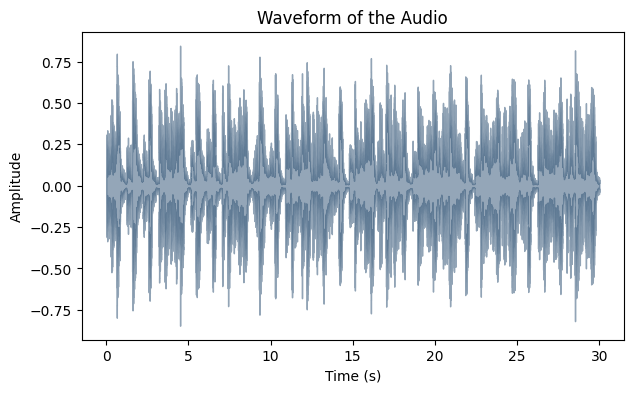

In [8]:
# Wave form of the audio
plt.figure(figsize=(7,4))
librosa.display.waveshow(data,color="#2B4F72", alpha = 0.5)
plt.title("Waveform of the Audio")

plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
plt.show()

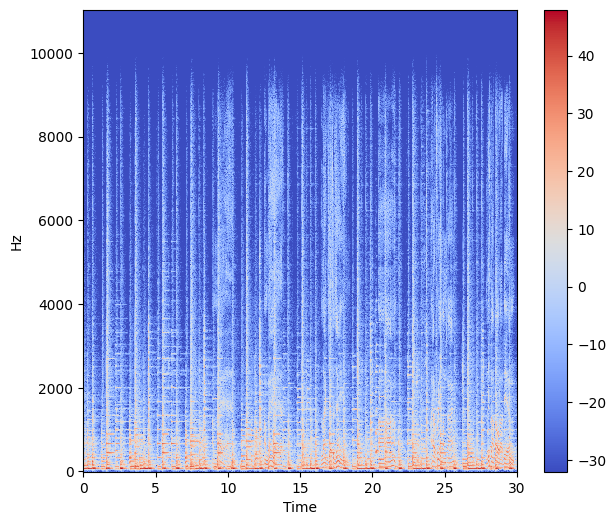

In [9]:
# Spectrogram of the audio
stft=librosa.stft(data)
stft_db=librosa.amplitude_to_db(abs(stft))
plt.figure(figsize=(7,6))
librosa.display.specshow(stft_db,sr=sr,x_axis='time',y_axis='hz')
plt.colorbar()

**Loading a single audio**

In [10]:
# Initializing sample rate to 45600 we obtain the signal value array
librosa.load(sample_audio,sr=45600)

# Taking Short-time Fourier transform of the signal
y = librosa.stft(data)  
S_db = librosa.amplitude_to_db(np.abs(y), ref=np.max)

# Playing audio file
IPython.display.Audio(data,rate=sr)

## 2. Feature Selection

1. **Chroma_STFT (Short-Time Fourier Transform):**  
   Represents the energy distribution across 12 pitch classes, effectively capturing harmonic content. This feature provides insight into the harmonic structure of the music.

2. **RMS (Root Mean Square Energy):**  
   Reflects the energy of the audio signal, making it useful for assessing dynamic range and detecting changes in intensity.

3. **Spectral Centroid:**  
   Indicates the "center of mass" of the spectrum, often perceived as the brightness of the sound. Higher values correlate with brighter sounds.

4. **Spectral Bandwidth:**  
   Describes the width of the spectral band, which is closely related to the timbral quality of the sound. It helps differentiate between fuller, richer sounds and those that are more narrow in spectral content.

5. **Zero Crossing Rate:**  
   The rate at which the signal changes sign. Often associated with noisiness, this feature is particularly useful for distinguishing between smooth and percussive or noisy audio textures.

6. **Tempo:**  
   Represents the tempo or speed of the audio, which is essential for detecting rhythmic patterns and classifying genres with distinct rhythmic structures.

7. **MFCCs (Mel-Frequency Cepstral Coefficients):**  
   Encodes timbral textures by capturing the spectral shape of the audio. Each MFCC coefficient provides a snapshot of the spectral content. The mean and variance of each MFCC are commonly used as features to capture a comprehensive view of the timbral characteristics.

These features will be extracted from the audio files to provide a robust representation of each track's musical attributes.

In [11]:
# Extracting features to match the exact index provided
sample_features = {}

# Chroma STFT
chroma_stft = librosa.feature.chroma_stft(y=data, sr=sr)
sample_features['chroma_stft_mean'] = np.mean(chroma_stft)
sample_features['chroma_stft_var'] = np.var(chroma_stft)

# RMS Energy
rms = librosa.feature.rms(y=data)
sample_features['rms_mean'] = np.mean(rms)
sample_features['rms_var'] = np.var(rms)

# Spectral Centroid
spectral_centroid = librosa.feature.spectral_centroid(y=data, sr=sr)
sample_features['spectral_centroid_mean'] = np.mean(spectral_centroid)
sample_features['spectral_centroid_var'] = np.var(spectral_centroid)

# Spectral Bandwidth
spectral_bandwidth = librosa.feature.spectral_bandwidth(y=data, sr=sr)
sample_features['spectral_bandwidth_mean'] = np.mean(spectral_bandwidth)
sample_features['spectral_bandwidth_var'] = np.var(spectral_bandwidth)

# Spectral Rolloff
rolloff = librosa.feature.spectral_rolloff(y=data, sr=sr)
sample_features['rolloff_mean'] = np.mean(rolloff)
sample_features['rolloff_var'] = np.var(rolloff)

# Zero Crossing Rate
zero_crossing_rate = librosa.feature.zero_crossing_rate(y=data)
sample_features['zero_crossing_rate_mean'] = np.mean(zero_crossing_rate)
sample_features['zero_crossing_rate_var'] = np.var(zero_crossing_rate)

# Harmonic and Perceptual (Percussive) Components
harmony = librosa.effects.harmonic(y=data)
perceptr = librosa.effects.percussive(y=data)
sample_features['harmony_mean'] = np.mean(harmony)
sample_features['harmony_var'] = np.var(harmony)
sample_features['perceptr_mean'] = np.mean(perceptr)
sample_features['perceptr_var'] = np.var(perceptr)

# Tempo
tempo, _ = librosa.beat.beat_track(y=data, sr=sr, hop_length=512)
sample_features['tempo'] = tempo

# MFCCs (20 coefficients, each with mean and variance)
mfccs = librosa.feature.mfcc(y=data, sr=sr, n_mfcc=20)
for i in range(1, 21):
    sample_features[f'mfcc{i}_mean'] = np.mean(mfccs[i-1, :])
    sample_features[f'mfcc{i}_var'] = np.var(mfccs[i-1, :])

# Add a label if necessary
sample_features['label'] = 'sample_genre'  # Replace with actual label if available

# Convert to DataFrame for a single row
sample_df = pd.DataFrame([sample_features])

# Display the DataFrame
print("Extracted Features DataFrame for Sample Audio:")
sample_df

Extracted Features DataFrame for Sample Audio:


chroma_stft_mean  chroma_stft_var  rms_mean   rms_var  \
0          0.404854         0.093999   0.14104  0.006348   

   spectral_centroid_mean  spectral_centroid_var  spectral_bandwidth_mean  \
0             1070.153418          184366.009385              1596.422565   

   spectral_bandwidth_var  rolloff_mean   rolloff_var  ...  mfcc16_var  \
0           166551.844323   2184.879029  1.493078e+06  ...   44.432896   

   mfcc17_mean  mfcc17_var  mfcc18_mean  mfcc18_var  mfcc19_mean mfcc19_var  \
0    -3.324069   50.218452     0.636311   37.325726    -0.615968  37.257774   

   mfcc20_mean  mfcc20_var         label  
0    -3.405046   31.965254  sample_genre  

[1 rows x 58 columns]

For the dataset we have, the process we applied to extract features from the sample audio file was performed on every audio file in the collection. For each file, we calculated a set of detailed audio features—such as Chroma STFT, RMS Energy, Spectral Centroid, Spectral Bandwidth, Zero Crossing Rate, Harmonic and Percussive components, Tempo, and MFCCs—capturing both the mean and variance for each feature across the entire 30-second duration. This systematic extraction of features for all files resulted in the comprehensive dataset we loaded, with each row representing an audio file and each column corresponding to a specific feature’s mean or variance.

### i. Visualising the Features 

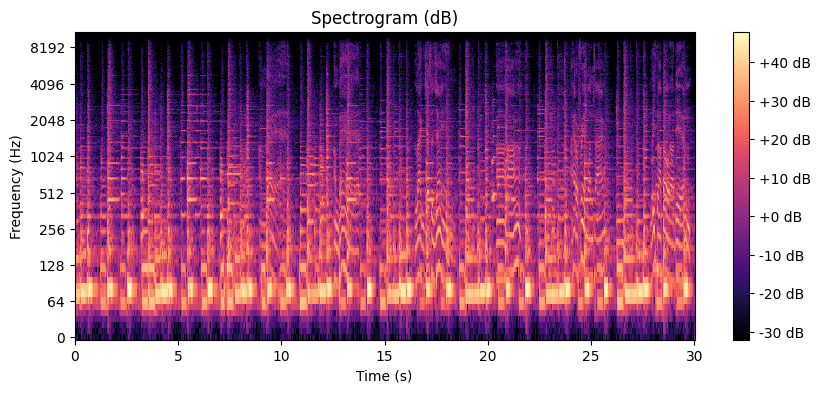

In [12]:
# Short-Time Fourier Transform (STFT)
spectrogram = librosa.stft(data)
spectrogram_db = librosa.amplitude_to_db(abs(spectrogram))

# Plot the Spectrogram
plt.figure(figsize=(10, 4))
librosa.display.specshow(spectrogram_db, sr=sr, x_axis='time', y_axis='log', cmap='magma')
plt.colorbar(format='%+2.0f dB')
plt.title("Spectrogram (dB)")
plt.xlabel("Time (s)")
plt.ylabel("Frequency (Hz)")
plt.show()


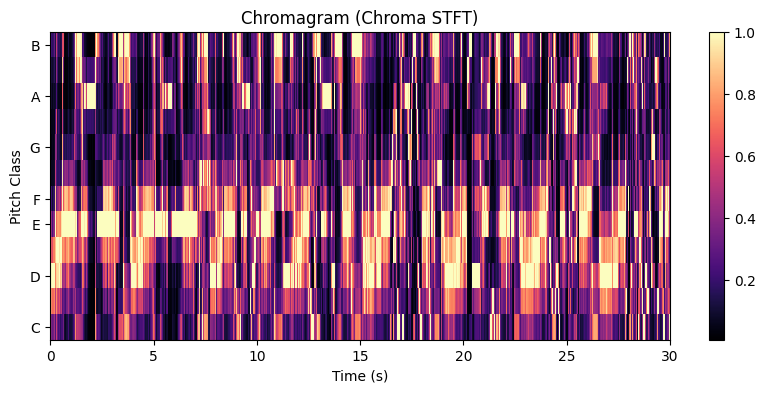

In [13]:
# Plot the Chromagram
plt.figure(figsize=(10, 4))
librosa.display.specshow(chroma_stft, sr=sr, x_axis='time', y_axis='chroma', cmap='magma')
plt.colorbar()
plt.title("Chromagram (Chroma STFT)")
plt.xlabel("Time (s)")
plt.ylabel("Pitch Class")
plt.show()

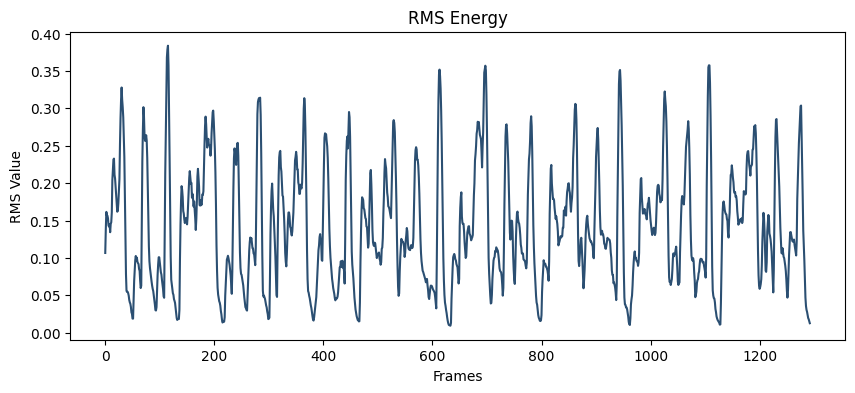

In [14]:
# RMS Energy
rms = librosa.feature.rms(y=data)[0]

# Plot RMS Energy
plt.figure(figsize=(10, 4))
plt.plot(rms, color="#2B4F72")
plt.title("RMS Energy")
plt.xlabel("Frames")
plt.ylabel("RMS Value")
plt.show()

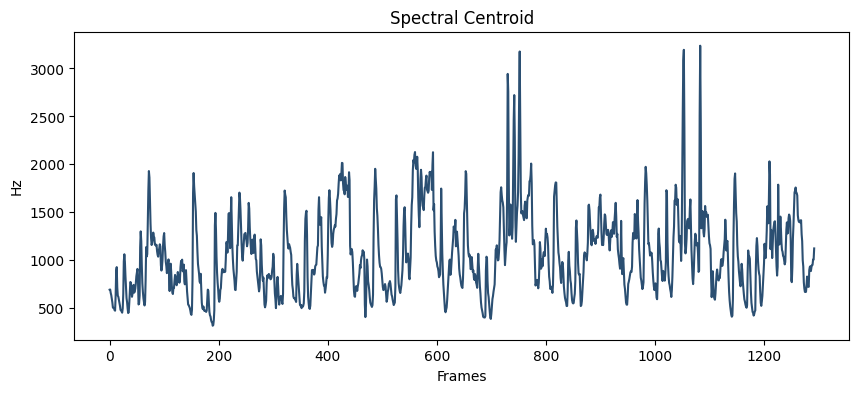

In [15]:
# Spectral Centroid
spectral_centroid = librosa.feature.spectral_centroid(y=data, sr=sr)[0]

# Plot Spectral Centroid
plt.figure(figsize=(10, 4))
plt.plot(spectral_centroid, color="#2B4F72")
plt.title("Spectral Centroid")
plt.xlabel("Frames")
plt.ylabel("Hz")
plt.show()


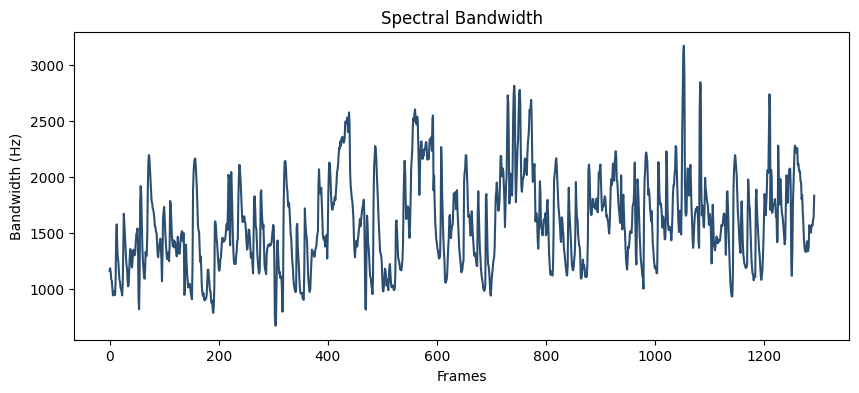

In [16]:
# Spectral Bandwidth
spectral_bandwidth = librosa.feature.spectral_bandwidth(y=data, sr=sr)[0]

# Plot Spectral Bandwidth
plt.figure(figsize=(10, 4))
plt.plot(spectral_bandwidth, color="#2B4F72")
plt.title("Spectral Bandwidth")
plt.xlabel("Frames")
plt.ylabel("Bandwidth (Hz)")
plt.show()


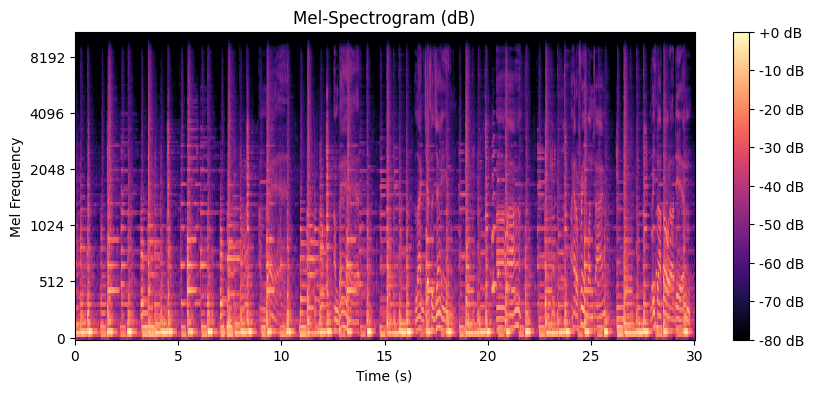

In [17]:
# Mel-Spectrogram
mel_spectrogram = librosa.feature.melspectrogram(y=data, sr=sr)
mel_spectrogram_db = librosa.power_to_db(mel_spectrogram, ref=np.max)

# Plot the Mel-Spectrogram
plt.figure(figsize=(10, 4))
librosa.display.specshow(mel_spectrogram_db, sr=sr, x_axis='time', y_axis='mel', cmap='magma')
plt.colorbar(format='%+2.0f dB')
plt.title("Mel-Spectrogram (dB)")
plt.xlabel("Time (s)")
plt.ylabel("Mel Frequency")
plt.show()

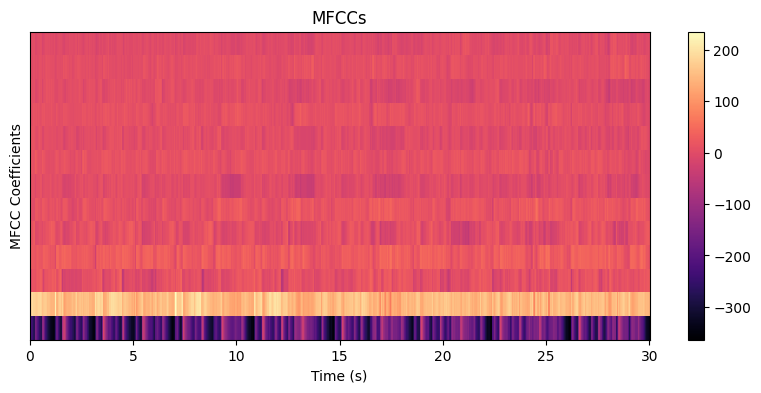

In [18]:
# MFCCs
mfccs = librosa.feature.mfcc(y=data, sr=sr, n_mfcc=13)

# Plot the MFCCs
plt.figure(figsize=(10, 4))
librosa.display.specshow(mfccs, sr=sr, x_axis='time', cmap='magma')
plt.colorbar()
plt.title("MFCCs")
plt.xlabel("Time (s)")
plt.ylabel("MFCC Coefficients")
plt.show()

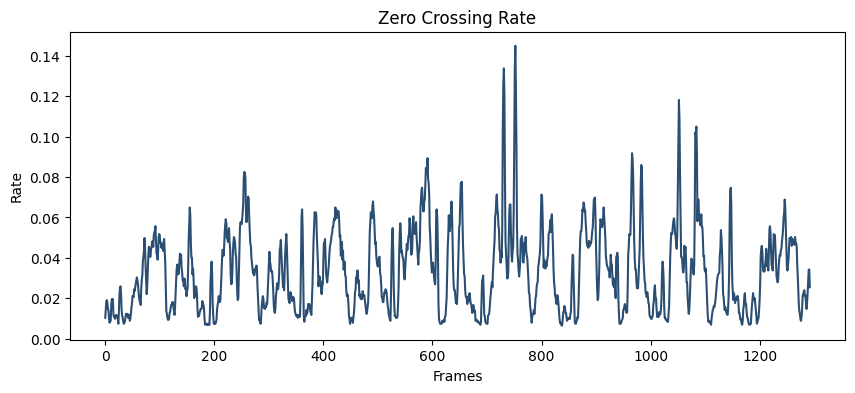

In [19]:
# Zero Crossing Rate
zcr = librosa.feature.zero_crossing_rate(data)[0]

# Plot Zero Crossing Rate
plt.figure(figsize=(10, 4))
plt.plot(zcr, color="#2B4F72")
plt.title("Zero Crossing Rate")
plt.xlabel("Frames")
plt.ylabel("Rate")
plt.show()

## 3. Exploratory Data Analysis

The waveform and mel-spectrogram visualizations offer complementary insights into the audio's structure and characteristics for each genre:

1. **Waveform**: The waveform plot on the left shows the amplitude (loudness) of the audio signal over time. Peaks and valleys represent dynamic changes in volume. This visualization helps us identify the energy distribution and dynamics over time, which can indicate the rhythm and intensity patterns characteristic of certain genres. 

2. **Mel-Spectrogram**:The mel-spectrogram displays frequency content over time, with color representing intensity in decibels. The horizontal axis represents time, the vertical axis represents frequency, and the color intensity indicates amplitude at a particular frequency. This visualization reveals timbral qualities and frequency emphasis. High-frequency components, as well as their absence or prominence, can indicate whether a genre relies on "bright" sounds (higher frequencies) or "darker" sounds (lower frequencies).

Together, these plots provide a comprehensive view of each genre's unique audio signature, combining both temporal dynamics (waveform) and frequency characteristics (mel-spectrogram). This analysis helps us understand patterns in amplitude and spectral content across genres, which are valuable in identifying genre-specific traits and supporting classification efforts.

In [20]:
# Get distinct values for 'label' column
genres = music['label'].unique()
print("Distinct Genres:", genres)

Distinct Genres: ['blues' 'classical' 'country' 'disco' 'hiphop' 'jazz' 'metal' 'pop'
 'reggae' 'rock']


BLUES


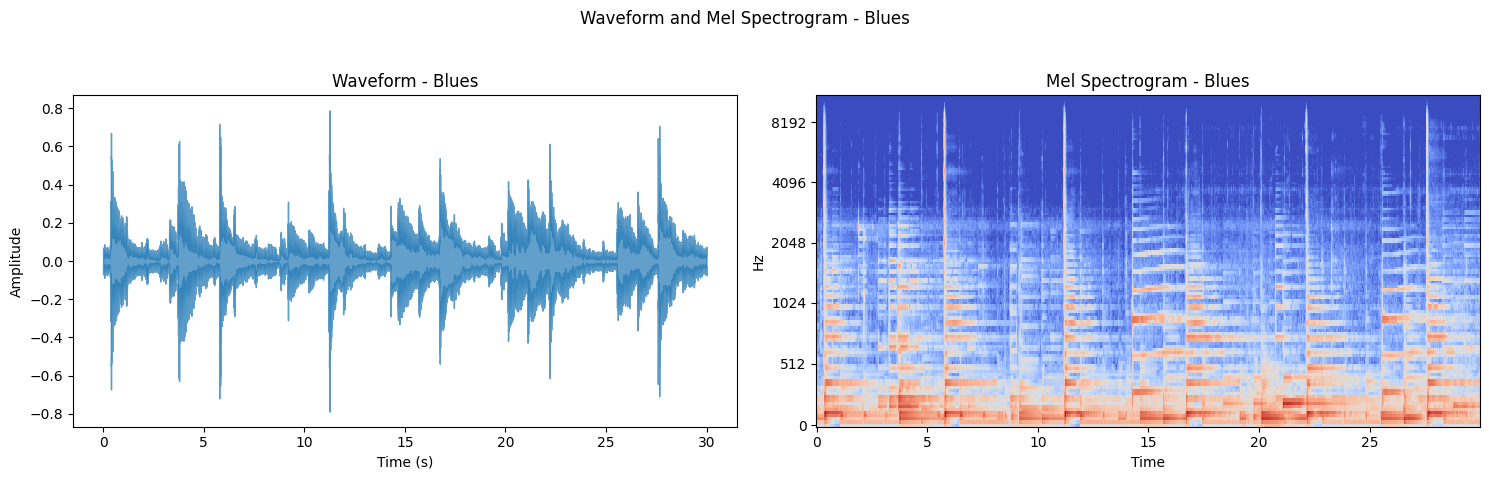

CLASSICAL


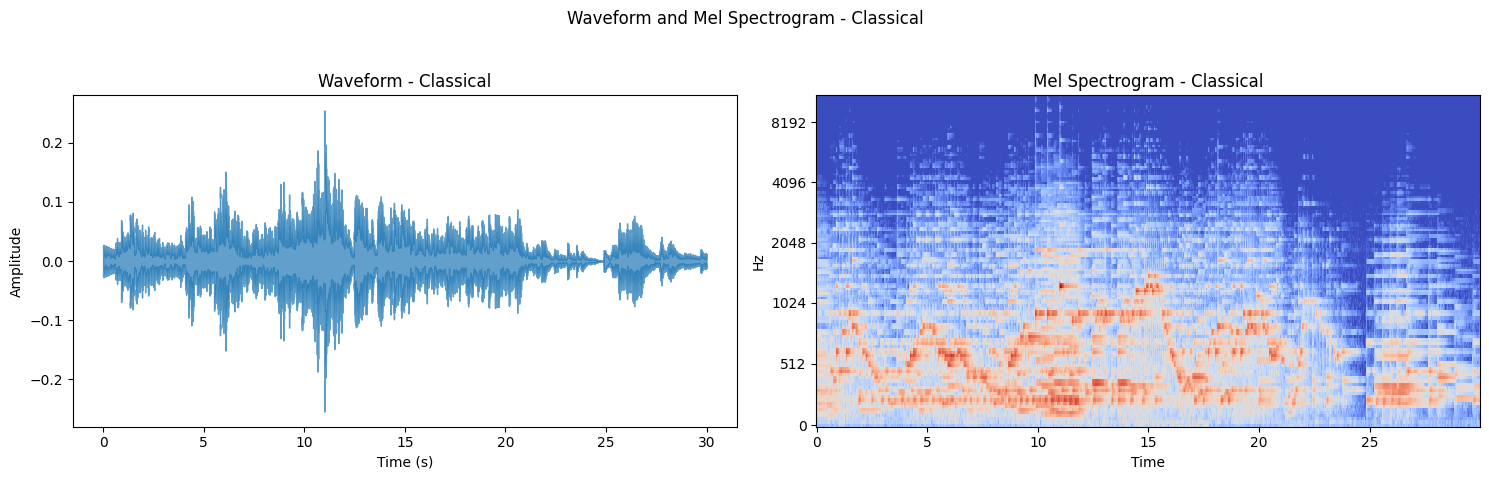

COUNTRY


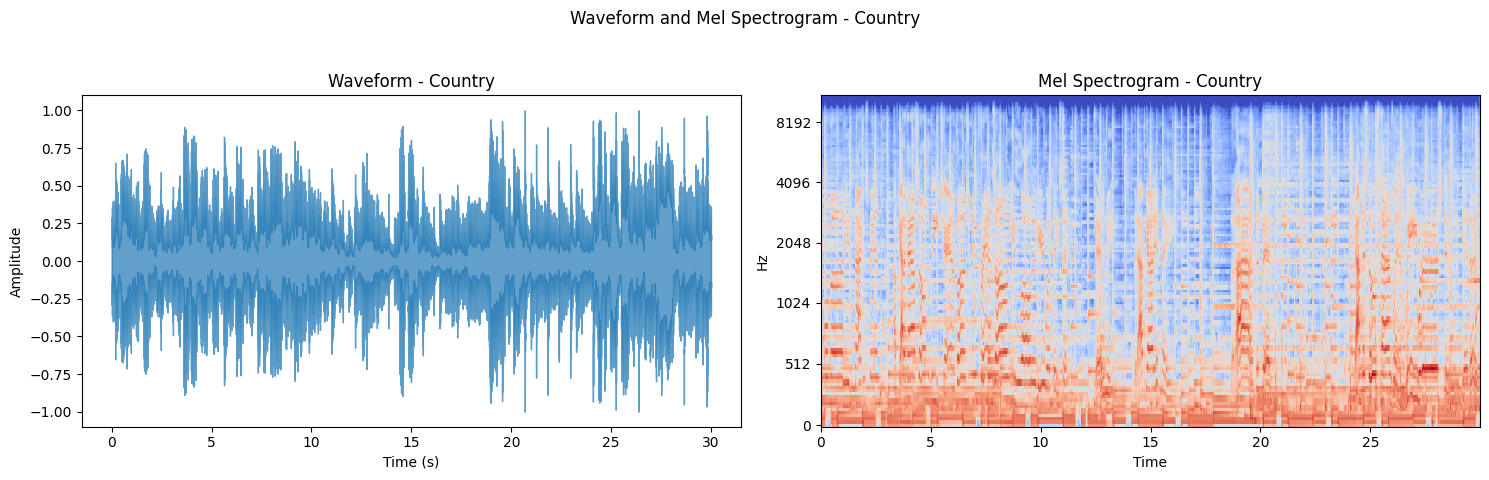

DISCO


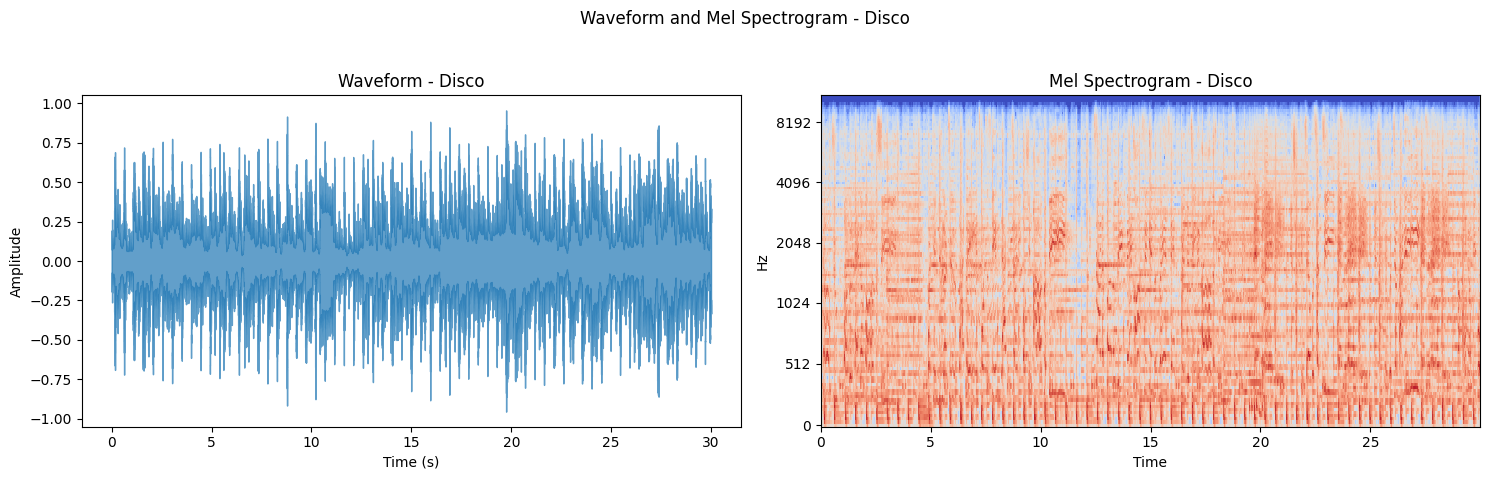

HIPHOP


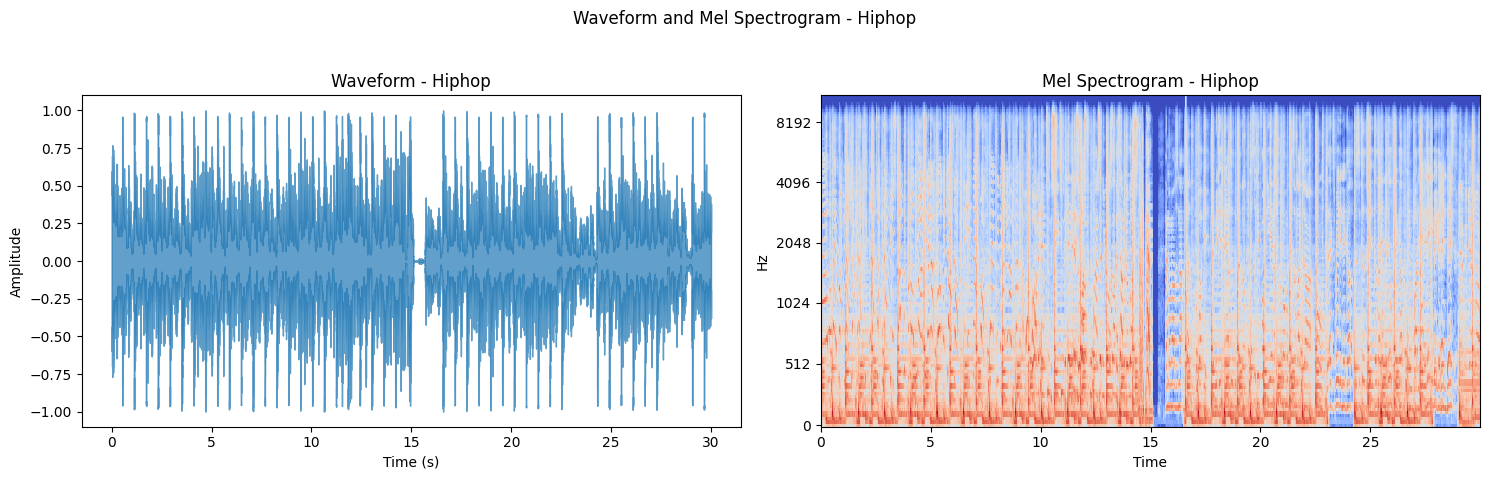

JAZZ


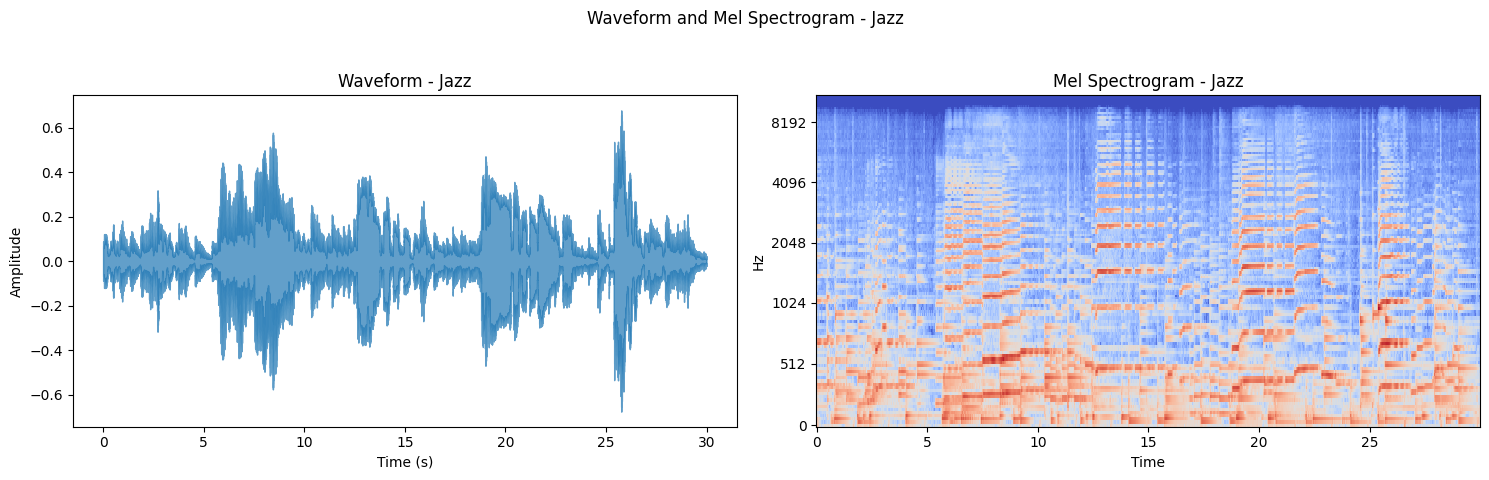

METAL


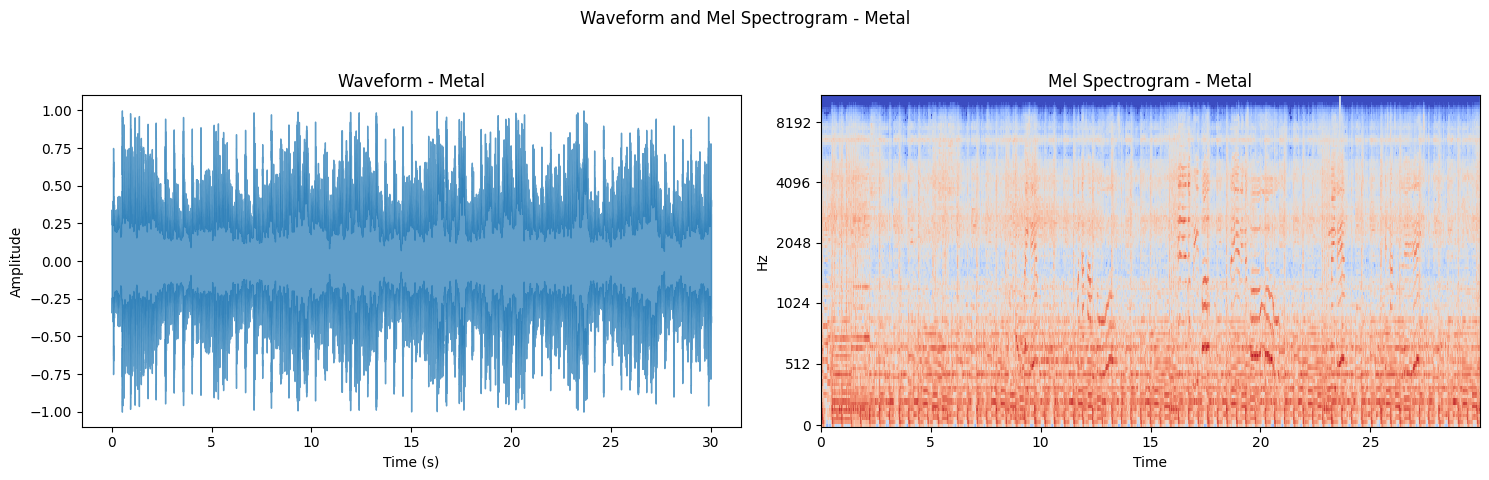

POP


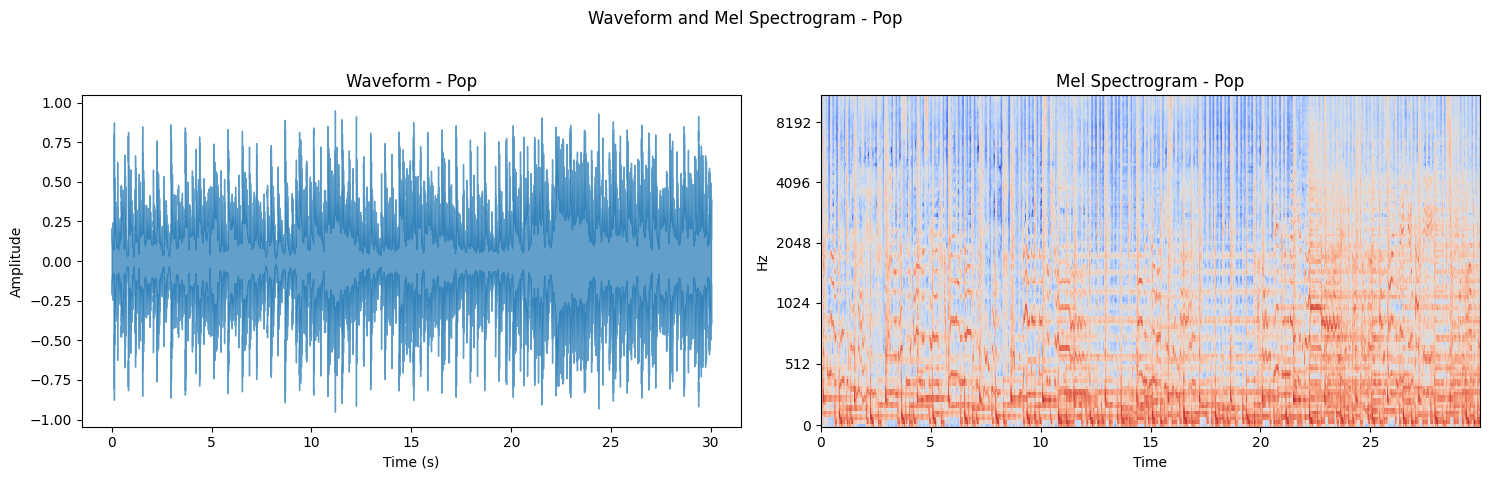

REGGAE


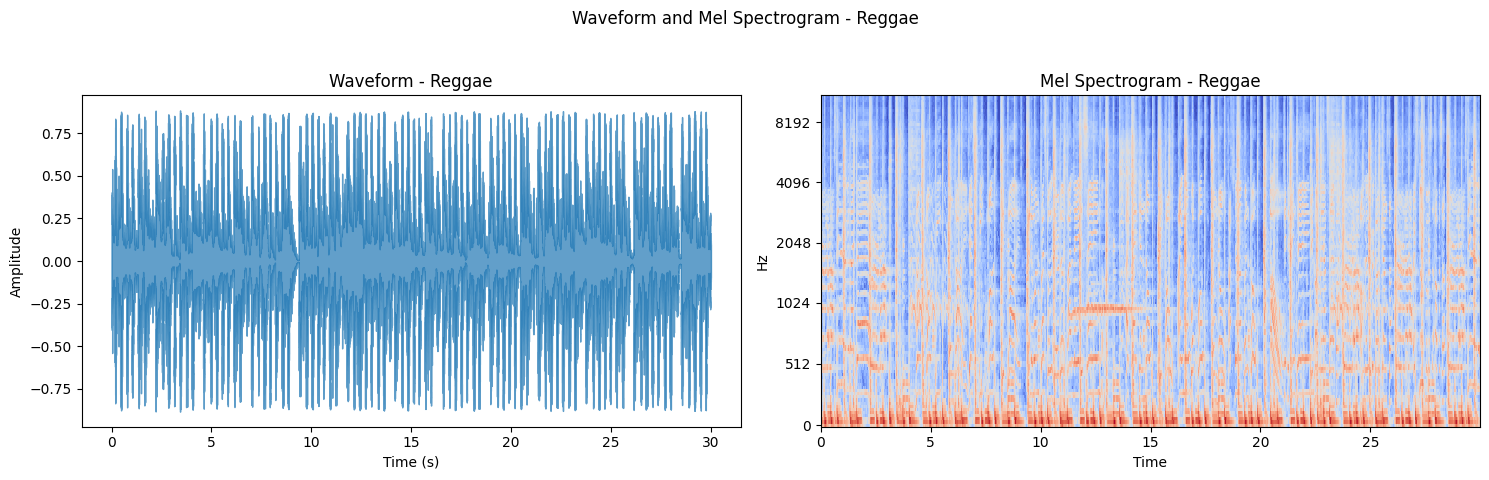

ROCK


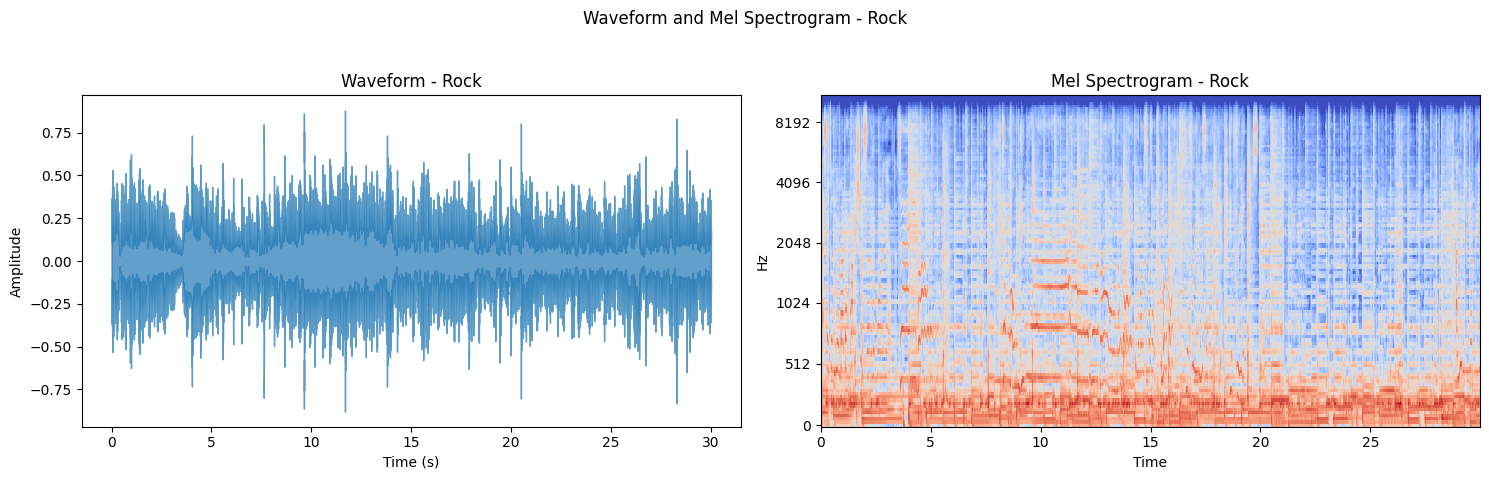

In [21]:
# Loop over each genre and create separate plots for each genre
for genre in genres:
    # Get the first audio file for the current genre
    genre_index = np.where(audio_label == genre)[0][0]  # Get the index of the first file in this genre
    y, sr = librosa.load(audio_paths[genre_index], duration=30)
    
    # Display audio playback widget
    print(f"\033[1m{genre.upper()}\033[0m")

    
    # Create a new figure for each genre to avoid stacking all plots together
    fig, axes = plt.subplots(1, 2, figsize=(15, 5))
    fig.suptitle(f"Waveform and Mel Spectrogram - {genre.capitalize()}")
    
    # Waveform
    librosa.display.waveshow(y, sr=sr, alpha=0.7, ax=axes[0])
    axes[0].set_title(f"Waveform - {genre.capitalize()}")
    axes[0].set_xlabel("Time (s)")
    axes[0].set_ylabel("Amplitude")
    
    # Mel Spectrogram
    mel_spectrogram = librosa.feature.melspectrogram(y=y, sr=sr)
    mel_spectrogram_db = librosa.power_to_db(mel_spectrogram, ref=np.max)
    librosa.display.specshow(mel_spectrogram_db, sr=sr, x_axis='time', y_axis='mel', cmap='coolwarm', ax=axes[1])
    axes[1].set_title(f"Mel Spectrogram - {genre.capitalize()}")
    
    # Adjust layout for each individual figure
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

## 4. Model Building 

In [22]:
# Define feature columns and target column
feature_columns = music.columns[:-1] 
target_column = 'label'

# Set up X (features) and y (labels)
X = music[feature_columns].values  # Convert feature columns to numpy array
y = music[target_column].values  # Target labels

# Initialize the scaler and scale the feature data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [23]:
# Instantiate the LabelEncoder
label_encoder = LabelEncoder()

# Encode the genre labels to numerical values
y_encoded = label_encoder.fit_transform(y)

# Mapping dictionary to show the integer assigned to each genre label
label_mapping = dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))

# Display the label mapping in a clear list format
label_mapping_list = [f"{genre.capitalize()}: {code}" for genre, code in label_mapping.items()]
print("\033[1;34mLabel Mapping:\033[0m") 
for item in sorted(label_mapping_list):  # Sorting for consistent order
    print(item)

Label Mapping:
Blues: 0
Classical: 1
Country: 2
Disco: 3
Hiphop: 4
Jazz: 5
Metal: 6
Pop: 7
Reggae: 8
Rock: 9


## Model 1. KNN

In [24]:
# Use the preprocessed X_scaled and y_encoded
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_encoded, test_size=0.2, random_state=42)

In [25]:
# Define a range of k values to search
param_grid = {'n_neighbors': list(range(1, 21))}

# Initialize and fit GridSearchCV
grid_search = GridSearchCV(KNeighborsClassifier(), param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train, y_train)

# Get the best k value from the grid sea$rch results
best_k = grid_search.best_params_['n_neighbors']

# Initialize the KNN classifier with the optimal k value
knn_classifier = KNeighborsClassifier(n_neighbors=best_k)

# Train the optimized KNN model
knn_classifier.fit(X_train, y_train)

KNeighborsClassifier(n_neighbors=1)

In [26]:
# Predict on the test set using the optimized model
y_pred_KNN = knn_classifier.predict(X_test)

In [27]:
# Calculate accuracy for the optimized model
accuracy = accuracy_score(y_test, y_pred_KNN)
print(f"\033[1;34mKNN Accuracy:\033[0m {accuracy * 100:.2f}%")
print("")
# Detailed classification report
print("\033[1;34mRandom Forest Classification Report:\033[0m")
print("")
print(classification_report(y_test, y_pred_KNN, target_names=label_mapping.keys()))

KNN Accuracy: 91.99%

Random Forest Classification Report:

              precision    recall  f1-score   support

       blues       0.95      0.91      0.93       208
   classical       0.93      0.93      0.93       203
     country       0.86      0.83      0.85       186
       disco       0.88      0.92      0.90       199
      hiphop       0.96      0.94      0.95       218
        jazz       0.88      0.92      0.90       192
       metal       0.99      0.98      0.98       204
         pop       0.93      0.94      0.94       180
      reggae       0.91      0.94      0.92       211
        rock       0.91      0.88      0.89       197

    accuracy                           0.92      1998
   macro avg       0.92      0.92      0.92      1998
weighted avg       0.92      0.92      0.92      1998



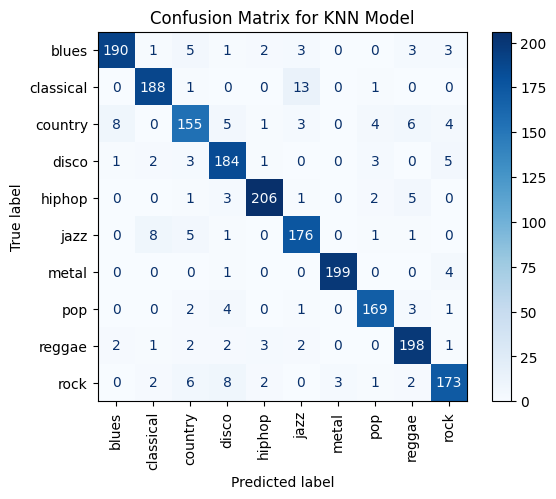

In [28]:
# Generate the confusion matrix
cm = confusion_matrix(y_test, y_pred_KNN)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_encoder.classes_)
disp.plot(cmap='Blues', xticks_rotation=90)
plt.title("Confusion Matrix for KNN Model")
plt.show()

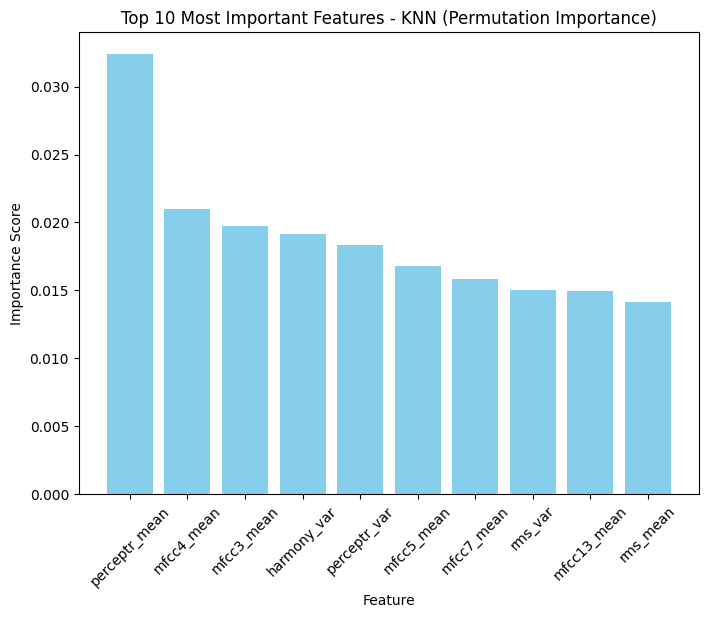

In [29]:
# Calculate permutation importance
result = permutation_importance(knn_classifier, X_test, y_test, n_repeats=10, random_state=42, scoring='accuracy')

# Get the actual feature names from the DataFrame
feature_names = music[feature_columns].columns  # Replace `music` with your actual DataFrame variable if different

# Calculate permutation importance
feature_importances = result.importances_mean
top_n = 10

# Sort features by importance and select the top 10
top_feature_indices = np.argsort(feature_importances)[::-1][:top_n]
top_feature_names = [feature_names[i] for i in top_feature_indices]  # Use actual feature names
top_feature_importance = feature_importances[top_feature_indices]

# Plot the top 10 most important features
plt.figure(figsize=(8, 6))
plt.bar(top_feature_names, top_feature_importance, color='skyblue')
plt.xlabel('Feature')
plt.ylabel('Importance Score')
plt.title('Top 10 Most Important Features - KNN (Permutation Importance)')
plt.xticks(rotation=45)
plt.show()

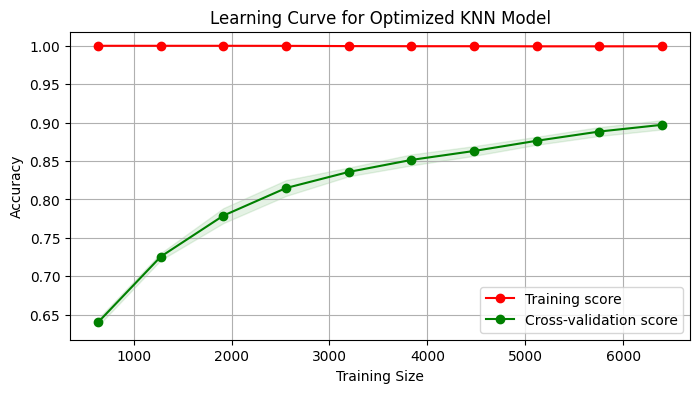

In [30]:
# Generate the learning curve using the optimized KNN model
train_sizes, train_scores, test_scores = learning_curve(
    knn_classifier, X_train, y_train, cv=5, scoring='accuracy', n_jobs=-1, train_sizes=np.linspace(0.1, 1.0, 10)
)

# Calculate mean and std for train and test scores
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

# Plot learning curve
plt.figure(figsize=(8, 4))
plt.plot(train_sizes, train_mean, 'o-', color="r", label="Training score")
plt.plot(train_sizes, test_mean, 'o-', color="g", label="Cross-validation score")
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, color="r", alpha=0.1)
plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, color="g", alpha=0.1)
plt.xlabel("Training Size")
plt.ylabel("Accuracy")
plt.title("Learning Curve for Optimized KNN Model")
plt.legend(loc="best")
plt.grid()
plt.show()

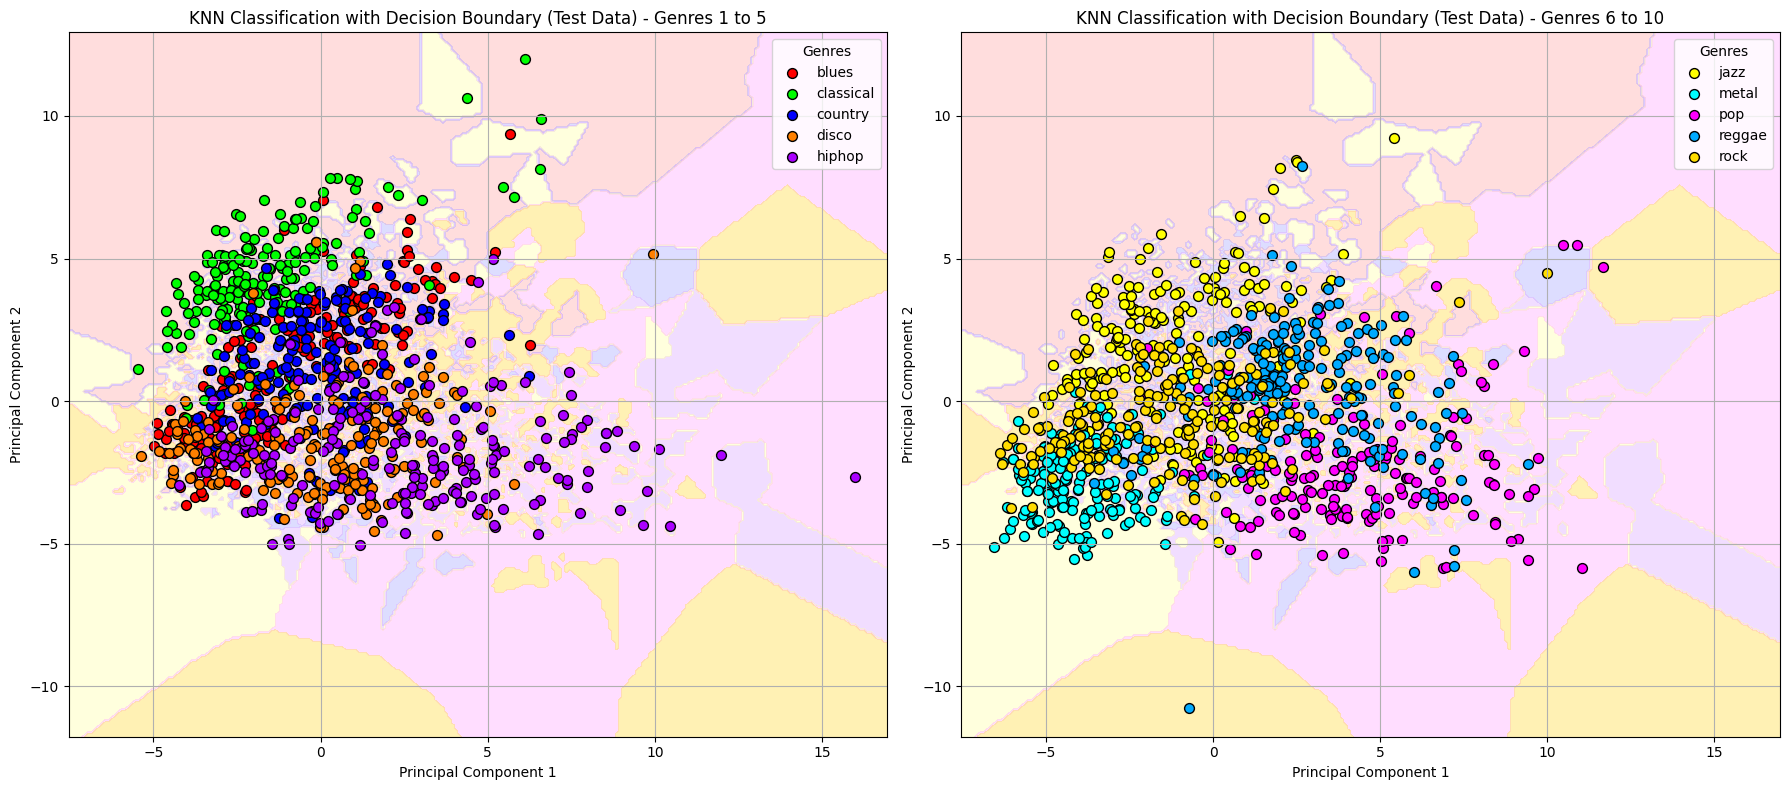

In [31]:
# Step 1: Reduce the features to 2D using PCA for visualization
pca = PCA(n_components=2)
X_test_reduced = pca.fit_transform(X_test)
X_train_reduced = pca.transform(X_train)

# Step 2: Fit the optimized KNN on the 2D data (for visualization purposes)
knn_classifier.fit(X_train_reduced, y_train)

# Step 3: Set up meshgrid for decision boundary plotting
x_min, x_max = X_test_reduced[:, 0].min() - 1, X_test_reduced[:, 0].max() + 1
y_min, y_max = X_test_reduced[:, 1].min() - 1, X_test_reduced[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1),
                     np.arange(y_min, y_max, 0.1))

# Step 4: Predict on the meshgrid to get boundary values
Z = knn_classifier.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

# Color maps for decision boundaries and test points
cmap_light = ListedColormap(['#FFAAAA', '#AAFFAA', '#AAAAFF', '#FFCCAA', '#DDAAFF', '#FFFFAA', '#AAFFFF', '#FFAAFF', '#AADDFF', '#FFDD44'])
cmap_bold = ['#FF0000', '#00FF00', '#0000FF', '#FF8000', '#AA00FF', '#FFFF00', '#00FFFF', '#FF00FF', '#00AAFF', '#FFDD00']

# Split genres into two groups
genre_groups = [np.unique(y_test)[:5], np.unique(y_test)[5:]]

# Create a 1x2 grid for side-by-side plotting
fig, axes = plt.subplots(1, 2, figsize=(18, 8))

# Plot each group of 5 genres in separate subplots
for i, (genres, ax) in enumerate(zip(genre_groups, axes)):
    
    # Plot decision boundary on the current subplot
    ax.contourf(xx, yy, Z, alpha=0.4, cmap=cmap_light)
    
    # Plot test points for the specific genres in this subplot
    for genre in genres:
        idx = np.where(y_test == genre)
        ax.scatter(X_test_reduced[idx, 0], X_test_reduced[idx, 1], 
                   c=[cmap_bold[genre]], label=label_encoder.inverse_transform([genre])[0], edgecolor='k', s=50)
    
    # Set labels and titles for each subplot
    ax.set_xlabel('Principal Component 1')
    ax.set_ylabel('Principal Component 2')
    ax.set_title(f"KNN Classification with Decision Boundary (Test Data) - Genres {i*5 + 1} to {i*5 + 5}")
    ax.legend(title="Genres")
    ax.grid(True)

# Display the combined plot
plt.tight_layout()
plt.show()

This visualization shows the K-Nearest Neighbors (KNN) classification decision boundaries for predicting music genres, using two principal components that capture the main variance in the dataset. The two panels each focus on five genres: the left for blues, classical, country, disco, and hiphop and the right for jazz, metal, pop, reggae, and rock. Background colors represent the decision regions for each genre, while points are individual songs, color-coded by their actual genre.

This plot includes the presence of distinct clusters for some genres, like classical and reggae, which lie mostly within their boundaries, showing that KNN classifies them with high confidence. In contrast, genres with overlapping characteristics, like rock and pop, have more blended regions, making classification challenging for KNN in these areas. This overlap suggests that additional features or a more complex model might be necessary for finer distinctions.

Overall, these decision boundary plots illustrate that while KNN can broadly separate genres, it struggles with closely related ones due to its reliance on local neighbor voting. This insight highlights the model’s strengths in distinguishing unique genres and its limitations with similar ones, informing potential next steps in refining the model or feature set.

## Model 2: Random Forest

In [32]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_encoded, test_size=0.2, random_state=42)

# Initialize the Random Forest model
random_forest_model = RandomForestClassifier(n_estimators=100, random_state=42)

# Train the Random Forest model
random_forest_model.fit(X_train, y_train)

# Make predictions on the test set
y_pred_rf = random_forest_model.predict(X_test)

# Calculate the accuracy of the Random Forest model
rf_accuracy = accuracy_score(y_test, y_pred_rf)
print(f"\033[1;34mRandom Forest Accuracy:\033[0m {rf_accuracy * 100:.2f}%")
print("")

# Print the classification report for detailed performance metrics
print("\033[1;34mRandom Forest Classification Report:\033[0m")
print("")
print(classification_report(y_test, y_pred_rf, target_names=label_mapping.keys()))

Random Forest Accuracy: 88.29%

Random Forest Classification Report:

              precision    recall  f1-score   support

       blues       0.87      0.87      0.87       208
   classical       0.94      0.98      0.96       203
     country       0.80      0.84      0.82       186
       disco       0.85      0.83      0.84       199
      hiphop       0.92      0.89      0.90       218
        jazz       0.86      0.93      0.89       192
       metal       0.87      0.95      0.91       204
         pop       0.92      0.95      0.93       180
      reggae       0.92      0.88      0.90       211
        rock       0.89      0.72      0.79       197

    accuracy                           0.88      1998
   macro avg       0.88      0.88      0.88      1998
weighted avg       0.88      0.88      0.88      1998



<Figure size 1000x800 with 0 Axes>

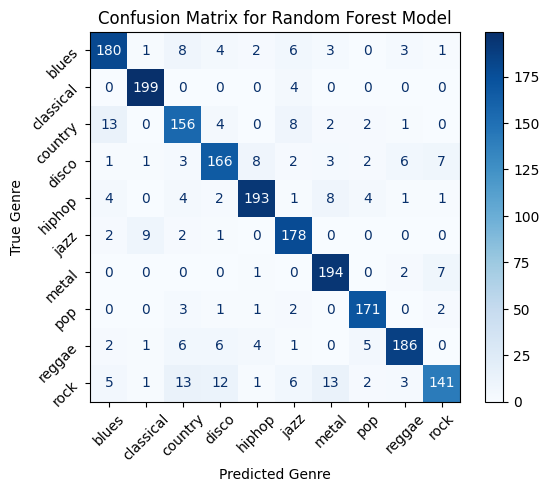

In [33]:
# Generate the confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred_rf)

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=label_mapping.keys())
disp.plot(cmap='Blues', values_format='d')
plt.title("Confusion Matrix for Random Forest Model")
plt.xlabel("Predicted Genre")
plt.ylabel("True Genre")
plt.xticks(rotation=45)
plt.yticks(rotation=45)
plt.show()

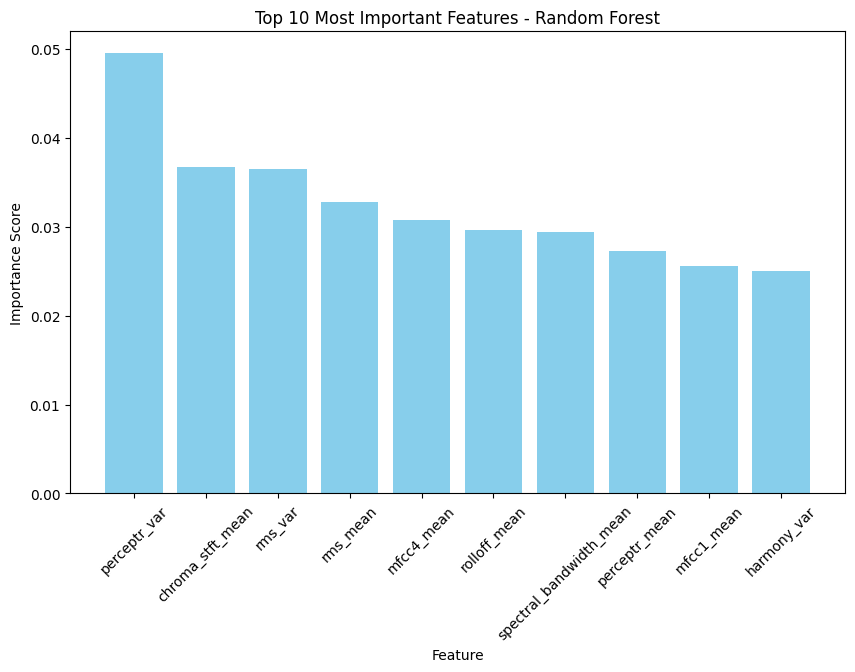

In [34]:
# Calculate feature importances from the Random Forest model
feature_importances = random_forest_model.feature_importances_

# Sort features by importance and select the top 10
top_n = 10
top_feature_indices = np.argsort(feature_importances)[::-1][:top_n]  # Indices of top 10 features

# Use original DataFrame's column names
top_feature_names = music.columns[top_feature_indices]  # Replace 'music' with the actual DataFrame variable if different
top_feature_importance = feature_importances[top_feature_indices]

# Plot the top 10 most important features
plt.figure(figsize=(10, 6))
plt.bar(top_feature_names, top_feature_importance, color='skyblue')
plt.xlabel('Feature')
plt.ylabel('Importance Score')
plt.title('Top 10 Most Important Features - Random Forest')
plt.xticks(rotation=45)
plt.show()

## Model 3: CNN

In [35]:
# Reshape data for Conv1D layers
X_reshaped = X_scaled.reshape(X_scaled.shape[0], X_scaled.shape[1], 1)

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_reshaped, y_encoded, test_size=0.2, random_state=42)

# Convert labels to categorical format
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

# Initializing the CNN
classifier = Sequential()

# Step 1 - First Convolutional Layer
classifier.add(Conv1D(filters=32, kernel_size=3, activation='relu', input_shape=(X_reshaped.shape[1], 1)))
classifier.add(MaxPooling1D(pool_size=2))
classifier.add(Dropout(0.3))

# Step 2 - Second Convolutional Layer
classifier.add(Conv1D(filters=64, kernel_size=3, activation='relu'))
classifier.add(MaxPooling1D(pool_size=2))
classifier.add(Dropout(0.3))

# Step 3 - Third Convolutional Layer
classifier.add(Conv1D(filters=128, kernel_size=3, activation='relu'))
classifier.add(MaxPooling1D(pool_size=2))
classifier.add(Dropout(0.3))

# Step 4 - Flattening
classifier.add(Flatten())

# Step 5 - Fully Connected Layers
classifier.add(Dense(units=128, activation='relu'))
classifier.add(Dropout(0.4))
classifier.add(Dense(units=64, activation='relu'))

# Output layer for multi-class classification (assuming 10 genres)
classifier.add(Dense(units=10, activation='softmax'))

# Compiling the CNN
classifier.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

# Display model summary
classifier.summary()

# Training the CNN
history = classifier.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_test, y_test))


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 56, 32)         │           128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 28, 32)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 28, 32)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 26, 64)         │         6,208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_1 (MaxPooling1D)  │ (None, 13, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 13, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_2 (Conv1D)               │ (None, 11, 128)        │        24,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_2 (MaxPooling1D)  │ (None, 5, 128)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 5, 128)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 640)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │        82,048 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 10)             │           650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 121,994 (476.54 KB)

 Trainable params: 121,994 (476.54 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.1172 - loss: 2.3187 - val_accuracy: 0.2678 - val_loss: 2.1866
Epoch 2/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.2389 - loss: 2.1197 - val_accuracy: 0.3248 - val_loss: 1.8392
Epoch 3/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.3089 - loss: 1.8593 - val_accuracy: 0.3739 - val_loss: 1.7175
Epoch 4/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.3436 - loss: 1.7763 - val_accuracy: 0.4149 - val_loss: 1.6522
Epoch 5/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.3753 - loss: 1.7082 - val_accuracy: 0.4179 - val_loss: 1.6010
Epoch 6/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.3822 - loss: 1.6741 - val_accuracy: 0.4374 - val_loss: 1.5581
Epoch 7/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.3983 - loss: 1.6345 - val_accuracy: 0.4454 - val_loss: 1.5158
Epoch 8/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.3979 - loss: 1.6241 - val_accuracy: 0.

In [36]:
# Predict on test data
predictions = classifier.predict(X_test)

# Convert predictions (probabilities) to label indices
predicted_labels = np.argmax(predictions, axis=1)
true_labels = np.argmax(y_test, axis=1)

# Decode the integer predictions back to genre names using the label encoder
predicted_genres = label_encoder.inverse_transform(predicted_labels)
true_genres = label_encoder.inverse_transform(true_labels)

# Calculate and print total accuracy
total_accuracy = accuracy_score(true_labels, predicted_labels)
print("")
print(f"\033[1;34m\033[1mTotal Accuracy of CNN Model:\033[0m {total_accuracy * 100:.2f}%")
print("")

# Print classification report for precision, recall, and F1 score
print("\033[1;34m\033[1mCNN Model Classification Report:\033[0m")
print("")
print(classification_report(true_labels, predicted_labels, target_names=label_encoder.classes_))


63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step

Total Accuracy of CNN Model: 56.11%

CNN Model Classification Report:

              precision    recall  f1-score   support

       blues       0.54      0.55      0.55       208
   classical       0.76      0.94      0.84       203
     country       0.45      0.29      0.35       186
       disco       0.44      0.31      0.36       199
      hiphop       0.57      0.48      0.52       218
        jazz       0.60      0.63      0.61       192
       metal       0.56      0.86      0.68       204
         pop       0.52      0.76      0.62       180
      reggae       0.56      0.56      0.56       211
        rock       0.41      0.22      0.29       197

    accuracy                           0.56      1998
   macro avg       0.54      0.56      0.54      1998
weighted avg       0.54      0.56      0.54      1998



<Figure size 1000x800 with 0 Axes>

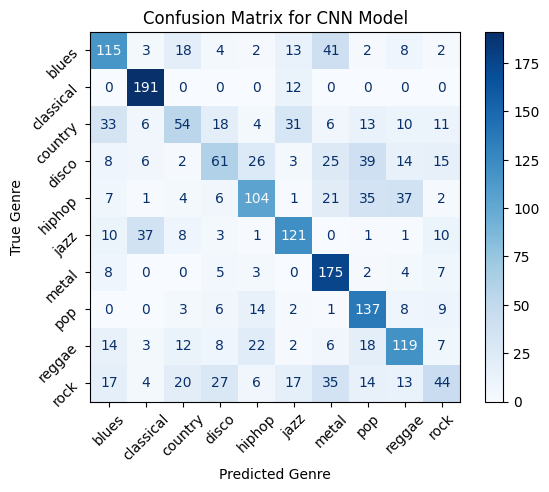

In [37]:
# Convert predictions (probabilities) to label indices
predicted_labels = np.argmax(predictions, axis=1)
true_labels = np.argmax(y_test, axis=1)

# Generate the confusion matrix
conf_matrix = confusion_matrix(true_labels, predicted_labels)

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=label_mapping.keys())
disp.plot(cmap='Blues', values_format='d')
plt.title("Confusion Matrix for CNN Model")
plt.xlabel("Predicted Genre")
plt.ylabel("True Genre")
plt.xticks(rotation=45)
plt.yticks(rotation=45)
plt.show()

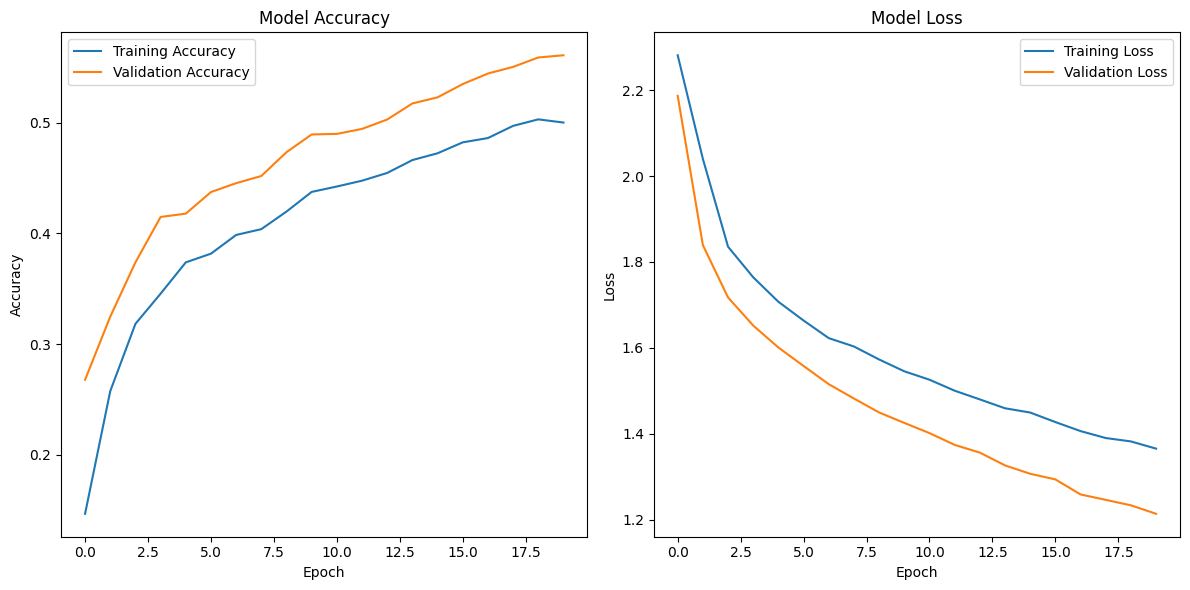

In [38]:
plt.figure(figsize=(12, 6))

# Plot accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.tight_layout()

# Plot loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.tight_layout()
plt.show()

## 5. Model Comparison

In [39]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, accuracy_score

# Check if y_test is one-hot encoded (multilabel-indicator format) and convert to integer labels
if y_test.ndim > 1:  # CNN output in one-hot encoding
    y_test_int = np.argmax(y_test, axis=1)
else:
    y_test_int = y_test  # Already in integer format

# Predictions for each model
y_pred_knn = y_pred_KNN  # Already in integer format
y_pred_rf = y_pred_rf          # Already in integer format 
y_pred_cnn = np.argmax(predictions, axis=1)

# CNN Model metrics
cnn_accuracy = accuracy_score(y_test_int, y_pred_cnn)
cnn_report = classification_report(y_test_int, y_pred_cnn, target_names=label_encoder.classes_, output_dict=True)
cnn_precision = cnn_report['macro avg']['precision']
cnn_recall = cnn_report['macro avg']['recall']
cnn_f1_score = cnn_report['macro avg']['f1-score']

# Calculate metrics for each model
# KNN Model metrics
knn_accuracy = accuracy_score(y_test_int, y_pred_knn)
knn_report = classification_report(y_test_int, y_pred_knn, target_names=label_encoder.classes_, output_dict=True)
knn_precision = knn_report['macro avg']['precision']
knn_recall = knn_report['macro avg']['recall']
knn_f1_score = knn_report['macro avg']['f1-score']

# Random Forest Model metrics
rf_accuracy = accuracy_score(y_test_int, y_pred_rf)
rf_report = classification_report(y_test_int, y_pred_rf, target_names=label_encoder.classes_, output_dict=True)
rf_precision = rf_report['macro avg']['precision']
rf_recall = rf_report['macro avg']['recall']
rf_f1_score = rf_report['macro avg']['f1-score']


# Create a DataFrame to display metrics
metrics_summary_df = pd.DataFrame({
    'Model': ['KNN', 'Random Forest','CNN'],
    'Accuracy': [knn_accuracy, rf_accuracy,cnn_accuracy],
    'Precision': [knn_precision, rf_precision,cnn_precision],
    'Recall': [knn_recall, rf_recall,cnn_recall],
    'F1-Score': [knn_f1_score, rf_f1_score,cnn_f1_score]
})

metrics_summary_df

Model  Accuracy  Precision    Recall  F1-Score
0            KNN  0.919920   0.919289  0.919009  0.918962
1  Random Forest  0.882883   0.882689  0.882920  0.881373
2            CNN  0.561061   0.541887  0.560418  0.538877

## Model Selection 

## KNN

Based on the results, the **K-Nearest Neighbors (KNN)** model emerges as the **most effective model for genre prediction**. It outperforms the other models, including Random Forest and Convolutional Neural Network (CNN), across key performance metrics such as **accuracy, precision, recall, and F1-score**. With an **accuracy of approximately 91.99%**, KNN demonstrates a strong ability to classify genres correctly, significantly higher than the Random Forest model’s 88.29% and the CNN model's 56.91%. The high **precision and recall values of KNN** indicate that it effectively balances both correct positive classifications and minimizing false negatives, making it a **reliable choice for this task**.

The effectiveness of KNN can be attributed to its simplicity and its reliance on feature similarity, which works well with our dataset of music attributes, such as chroma, spectral features, and MFCCs (Mel-frequency cepstral coefficients). These features capture essential patterns and characteristics of audio signals, allowing KNN to leverage proximity in feature space to make accurate predictions. Given its superior performance and robustness in classifying genres with minimal complexity, KNN is the ideal choice for our genre prediction model.

## 6. Model Predictions

In [40]:
# Convert y_test to integer labels if it's one-hot encoded
if y_test.ndim > 1:  # If y_test is one-hot encoded
    y_test_int = np.argmax(y_test, axis=1)
else:
    y_test_int = y_test  # Already in integer format

# Select 10 random indices from the test set
random_indices = np.random.choice(len(y_test_int), size=10, replace=False)

# Make predictions for these random samples using the KNN model
random_predictions = y_pred_KNN[random_indices]
random_true_labels = y_test_int[random_indices]

# Decode the numerical predictions and true labels back to genre names
predicted_genres = label_encoder.inverse_transform(random_predictions)
true_genres = label_encoder.inverse_transform(random_true_labels)

# Create a DataFrame to display the results in a tabular format
results_df = pd.DataFrame({
    "Predicted Genre": predicted_genres,
    "True Genre": true_genres
})

# Display the results table
print("\033[1;34mRandom Sample Predictions and True Labels:\033[0m")
results_df

Random Sample Predictions and True Labels:


Predicted Genre True Genre
0          hiphop     hiphop
1          reggae     reggae
2           metal      metal
3           blues      blues
4           metal      metal
5          hiphop     hiphop
6           metal      metal
7       classical  classical
8           metal      metal
9         country    country

## 7. Recommendations for Applying the Genre Prediction Model in the Music Industry

The genre prediction model developed here has a variety of potential applications in the music industry. Below are some recommended use cases where the model could be leveraged to enhance business operations, improve user experience, and inform strategic decision-making.

### 1. Personalized Music Recommendations

Streaming services can utilize this model to enhance their recommendation systems. By analyzing a user’s listening history and predicting genres for each song, streaming platforms can identify underrepresented genres in a user’s playlist and suggest similar but diverse genres to broaden their experience.
   - **Example**: If the model predicts a user mainly listens to "pop" and "hiphop," the recommendation algorithm could introduce "disco" or "jazz" tracks to create a more varied experience.

### 2. Target Genre Identification for New Artists
Record labels and artists can use genre predictions to identify the best genre fit for upcoming releases. The model’s genre predictions can help emerging artists or music producers understand where their music fits within the industry, allowing for more targeted marketing strategies and ensuring that the music resonates with its intended audience.
   - **Example**: If an artist’s song is predicted to belong to the "jazz" genre, the label can focus on jazz-oriented marketing channels and playlists to maximize reach.

### 3. Automated Playlist Curation
This model can streamline the curation of genre-based playlists. Streaming platforms and radio stations can use the genre predictions to automatically categorize new songs by genre and populate genre-specific playlists, saving time and ensuring that playlists stay up-to-date with dynamic updates.
   - **Example**: Genre predictions can be used to differentiate "upbeat jazz" from "chill jazz," offering more refined playlist options for listeners.

### 4. Efficient Music Licensing and Synchronization for Media
The genre prediction model can assist music supervisors in quickly finding genre-specific tracks for media projects. When selecting music for movies, TV shows, or advertisements, genre-specific filtering is essential, and this model enables efficient categorization to enhance the music selection process.
   - **Example**: By categorizing tracks by genre, supervisors can quickly locate songs that fit a particular mood or vibe, reducing search time for media projects.

### 5. Tracking Genre Trends for Strategic Decision-Making
Music platforms, labels, and producers can analyze genre trends over time to make data-informed decisions. By predicting the genre of a large catalog, the model can reveal trends in genre popularity, helping identify which genres are gaining traction.
   - **Example**: Labels can invest strategically in rising genres, adjust marketing efforts, and tailor playlisting strategies to maximize engagement with current trends.

### 6. Audience Demographic Matching
The model can assist in matching songs to specific demographic groups, refining marketing and release strategies. Different genres may appeal to particular demographic segments, and combining genre predictions with demographic data allows for more precise targeting of new releases.
   - **Example**: Marketers can identify target audiences (e.g., age groups, regions) for new releases and design campaigns to resonate with specific groups, maximizing engagement and response rates.


## CONCLUSION

By incorporating this genre prediction model into industry processes, music platforms and record labels can automate and enhance playlist curation, improve music recommendations, optimize marketing efforts, and make informed decisions about future trends and investments. This model not only streamlines operational tasks but also enhances the listening experience for users by introducing them to genres that align with their tastes and preferences. The versatility of the model allows it to be integrated into a wide array of music industry functions, driving efficiency and fostering a more engaging experience for audiences.

Implementing these recommendations can provide a strategic advantage, allowing companies in the music industry to leverage data-driven insights and cater more effectively to listeners’ evolving preferences.